#### Input

In [1]:
%load_ext autoreload
%matplotlib inline
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st

from helpers import helpplots as plothelp
from helpers import helpfunction as helper
from helpers import plot_dicts

<IPython.core.display.Javascript object>

In [3]:
%autoreload

<IPython.core.display.Javascript object>

### Constants

In [4]:
run = 1
input_dir = "./input/23Nov/".format(run)
output_dir = "./output/run{}/".format(run)

<IPython.core.display.Javascript object>

In [5]:
%%time
data = pickle.load(open(input_dir+"after_training_run{}.pckl".format(run), 'rb'))
samples = list(data.keys())

CPU times: user 269 ms, sys: 537 ms, total: 806 ms
Wall time: 805 ms


<IPython.core.display.Javascript object>

In [6]:
data["nue"]["daughters"].query("nslice>0")["category"].value_counts()

1     104535
11     85622
5      34655
10     14372
3         28
31        25
Name: category, dtype: int64

<IPython.core.display.Javascript object>

In [7]:
# Add the category cosmic:
for s in samples:
    if s not in helper.data_samples:
        cosmic = (data[s]["daughters"]["nu_purity_from_pfp"] < 0.5) & (
            data[s]["daughters"]["category"] != 5
        )
        data[s]["daughters"].loc[cosmic, "category"] = 4

<IPython.core.display.Javascript object>

In [8]:
nue_frame = data["nue"]["daughters"]
nue_mc = data["nue"]["mc"]
nue_frame.rename(columns={"selected": "preselection_roberto"}, inplace=True)

<IPython.core.display.Javascript object>

In [9]:
title_str = "MicroBooNE Run{}: {:.1e} POT".format(run, data["on"]["pot"])

<IPython.core.display.Javascript object>

### Evaluation

In [10]:
q_s = "(select & e_candidate)"

<IPython.core.display.Javascript object>

In [12]:
print(nue_frame.query("nslice>0")["true_category"].value_counts())
print()
print(nue_frame.query(q_s)["category"].value_counts())
print()
print(nue_frame.query(q_s)["interaction"].value_counts())

3    110733
2     90469
6     22863
1     15092
4        61
5        19
Name: true_category, dtype: int64

11    8965
1     4602
10    1658
5      189
4       94
Name: category, dtype: int64

0     7316
1     4946
10    1745
2     1464
3       37
Name: interaction, dtype: int64


<IPython.core.display.Javascript object>

In [13]:
print(pd.Series(nue_mc["category"]).value_counts())
print()
print(pd.Series(nue_mc["interaction"]).value_counts())
print()
print(pd.Series(nue_mc["true_category"]).value_counts())

11    28544
1     24335
0     18474
5     11509
10     6459
3         8
31        6
dtype: int64

0     34353
1     32732
2     12740
10     9196
3       314
dtype: int64

2    36688
3    30568
6    13452
1     8595
4       28
5        4
dtype: int64


<IPython.core.display.Javascript object>

### Plots

#### Signal sample plots

In [14]:
data["nue"]["daughters"].query("e_candidate>0 & preselect")[
    "shr_openangle_v"
].describe()

count    3.438800e+04
mean              NaN
std               inf
min     -2.232918e+38
25%     -3.514740e+00
50%      7.042213e-38
75%      1.492527e-01
max      3.045506e+38
Name: shr_openangle_v, dtype: float64

<IPython.core.display.Javascript object>

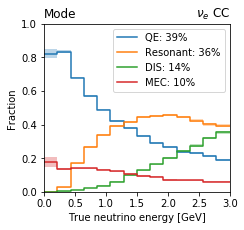

<IPython.core.display.Javascript object>

In [15]:
cats = [0, 1, 2, 10]
field = "nu_e"
x_min = 0
x_max = 3
n_bins = 15

fig, ax = plt.subplots(ncols=1, figsize=(3.5, 3.3))

for cat in cats:
    den = nue_mc[field]
    num = nue_mc[field][nue_mc["interaction"] == cat]

    den_w = nue_mc["weightSpline"]
    num_w = nue_mc["weightSpline"][nue_mc["interaction"] == cat]

    eff, unc_low, unc_up, edges = plothelp.efficiency_post(
        num, den, num_w=num_w, den_w=den_w, n_bins=n_bins, x_min=x_min, x_max=x_max
    )
    ax.fill_between(edges, eff - unc_low, eff + unc_up, alpha=0.3, step="post")
    ax.step(
        edges,
        eff,
        where="post",
        label="{0}: {1:.0f}%".format(
            plot_dicts.int_labels[cat], sum(num_w) / sum(den_w) * 100
        ),
    )
ax.set_title(r"$\nu_e$ CC", loc="right")
ax.set_title("Mode", loc="left")
ax.set_xlabel("True neutrino energy [GeV]")
ax.set_ylabel("Fraction")
ax.set_ylim(0, 1)
ax.set_xlim(x_min, x_max)
ax.legend(loc="upper right")

fig.tight_layout()

fig.savefig(output_dir + "truth_int.pdf", bbox_inches="tight")

/home/wouter/Documents/Jupyter/searchingfornues/helpers/helpplots.py:61: RuntimeWarning: invalid value encountered in true_divide
  eff = num_w_h / den_w_h


Purity: 0.1%
Purity: 2.1%
Purity: 39.2%


/home/wouter/Documents/Jupyter/searchingfornues/helpers/helpplots.py:61: RuntimeWarning: invalid value encountered in true_divide
  eff = num_w_h / den_w_h


Purity: 0.1%
Purity: 2.1%
Purity: 39.2%


/home/wouter/Documents/Jupyter/searchingfornues/helpers/helpplots.py:61: RuntimeWarning: invalid value encountered in true_divide
  eff = num_w_h / den_w_h


Purity: 0.1%
Purity: 2.1%
Purity: 39.2%


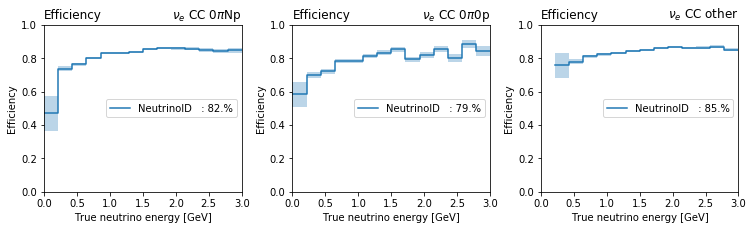

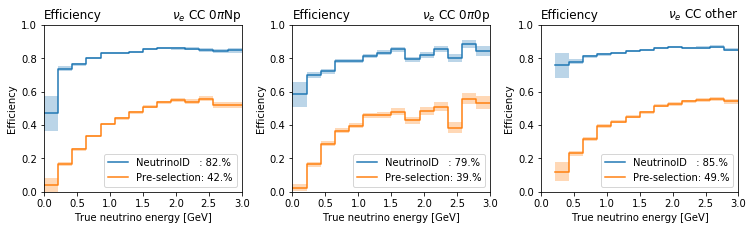

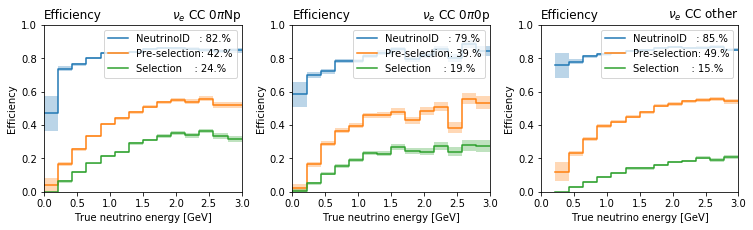

<IPython.core.display.Javascript object>

In [16]:
# eff per cat
cats = {2: 11, 1: 10, 3: 1}
field = "nu_e"
x_min = 0
x_max = 3
n_bins = 15
selectors = [
    "n_pfps>0 & daughter==0",
    "e_candidate & preselect",
    "e_candidate & select",
]  # q_s
labs = ["NeutrinoID", "Pre-selection", "Selection"]

for i in range(3):
    fig, axes = plt.subplots(ncols=3, figsize=(10.5, 3.3))

    for cat, ax in zip(cats.keys(), axes):
        for selector, lab in zip(selectors[: (i + 1)], labs):
            num = nue_frame.query(selector).query("true_category==@cat")[field]
            den = nue_mc[field][nue_mc["true_category"] == cat]

            num_w = nue_frame.query(selector).query("true_category==@cat")[
                "weightSpline"
            ]
            den_w = nue_mc["weightSpline"][nue_mc["true_category"] == cat]

            eff, unc_low, unc_up, edges = plothelp.efficiency_post(
                num,
                den,
                num_w=num_w,
                den_w=den_w,
                n_bins=n_bins,
                x_min=x_min,
                x_max=x_max,
            )
            ax.fill_between(edges, eff - unc_low, eff + unc_up, alpha=0.3, step="post")
            ax.step(
                edges,
                eff,
                where="post",
                label="{0:<13}: {1:#.2g}%".format(lab, sum(num_w) / sum(den_w) * 100),
            )
        ax.set_title(plot_dicts.category_labels[cats[cat]], loc="right")
        ax.set_title("Efficiency", loc="left")
        ax.set_xlabel("True neutrino energy [GeV]")
        ax.set_ylabel("Efficiency")
        ax.set_ylim(0, 1)
        ax.set_xlim(x_min, x_max)
        if i == 0:
            ax.legend(loc="center right")
        elif i == 1:
            ax.legend(loc="lower right")
        else:
            ax.legend(loc="upper right")

    fig.tight_layout()

    for selector in selectors:
        print(
            "Purity: {:.1f}%".format(
                100 * plothelp.get_purity(data, selector, cats.values())
            )
        )
    fig.savefig(output_dir + "efficiency_cat_" + str(i) + ".pdf", bbox_inches="tight")

/home/wouter/Documents/Jupyter/searchingfornues/helpers/helpplots.py:61: RuntimeWarning: invalid value encountered in true_divide
  eff = num_w_h / den_w_h


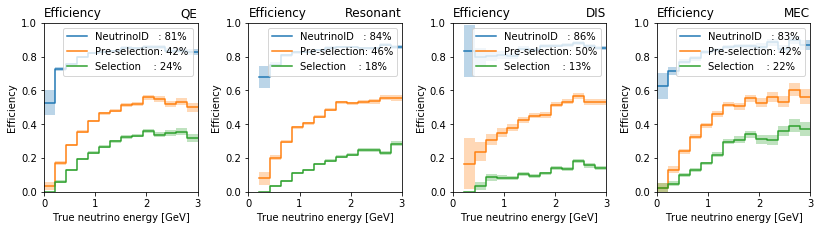

<IPython.core.display.Javascript object>

In [17]:
# eff per mode
cats = [0, 1, 2, 10]
field = "nu_e"
x_min = 0
x_max = 3
n_bins = 15
selectors = [
    "n_pfps>0 & daughter==0",
    "e_candidate & preselect",
    "e_candidate & select",
]  # q_s
labs = ["NeutrinoID", "Pre-selection", "Selection"]
fig, axes = plt.subplots(ncols=4, figsize=(11.5, 3.3))

for cat, ax in zip(cats, axes):
    for selector, lab in zip(selectors, labs):
        num = nue_frame.query(selector).query("interaction==@cat & nueccinc")[field]
        den = nue_mc[field][(nue_mc["interaction"] == cat) & nue_mc["nueccinc"] == 1]

        num_w = nue_frame.query(selector).query("interaction==@cat & nueccinc")[
            "weightSpline"
        ]
        den_w = nue_mc["weightSpline"][
            (nue_mc["interaction"] == cat) & nue_mc["nueccinc"] == 1
        ]

        eff, unc_low, unc_up, edges = plothelp.efficiency_post(
            num, den, num_w=num_w, den_w=den_w, n_bins=n_bins, x_min=x_min, x_max=x_max
        )
        ax.fill_between(edges, eff - unc_low, eff + unc_up, alpha=0.3, step="post")
        ax.step(
            edges,
            eff,
            where="post",
            label="{0:<13}: {1:.0f}%".format(lab, sum(num_w) / sum(den_w) * 100),
        )
    ax.set_title(plot_dicts.int_labels[cat], loc="right")
    ax.set_title("Efficiency", loc="left")
    ax.set_xlabel("True neutrino energy [GeV]")
    ax.set_ylabel("Efficiency")
    ax.set_ylim(0, 1)
    ax.set_xlim(x_min, x_max)
    ax.legend(loc="upper right")

fig.tight_layout()
fig.savefig(output_dir + "efficiency_int.pdf", bbox_inches="tight")

#### Nicolo Significance

In [18]:
def test_statistics_distribution_given_numbers(
    binning,
    expected_number,
    systematic_uncertainties={"nue": 0, "numu": 0, "dataext": 0, "dirt": 0},
    data_on=False,
    n_toy=10000,
    log=False,
):
    gauss = st.norm(0, 1)
    one_side_sig_percent = gauss.cdf(1) * 100

    systematic_uncertainties["nue_signal"] = systematic_uncertainties["nue"]
    systematic_uncertainties["nue_nonsignal"] = systematic_uncertainties["nue"]

    print(
        expected_number["nue"],
        expected_number["nue_signal"],
        expected_number["nue_nonsignal"],
    )

    mean_toy = {}
    poisson_toy = {}

    for sample in expected_number.keys():
        if sample == "data":
            continue

        mean_toy[sample] = np.random.normal(
            expected_number[sample],
            expected_number[sample] * systematic_uncertainties[sample],
            n_toy,
        )
        poisson_toy[sample] = np.random.poisson(mean_toy[sample])

    bkg_toy = (
        poisson_toy["numu"]
        + poisson_toy["dirt"]
        + poisson_toy["dataext"]
        + poisson_toy["nue_nonsignal"]
    )
    bkg_plus_signal_toy = bkg_toy + poisson_toy["nue_signal"]

    fig, ax = plt.subplots()
    bin_contents_total, bin_edges, _ = ax.hist(
        [bkg_plus_signal_toy, bkg_toy],
        bins=binning[0],
        range=(binning[1], binning[2]),
        density=True,
        label=["signal + background", "background only"],
        alpha=0.7,
        histtype="stepfilled",
        lw=2,
        log=log,
    )

    bin_width = (binning[2] - binning[1]) / binning[0]
    ax.set_ylabel("Probability / {:.2f}".format(bin_width))
    ax.set_xlabel("Test statistics = number of selected events")
    ymin, ymax = ax.get_ylim()

    # add expected pvalues
    percentage_values = [16, 50, 84]
    heights = {16: 0.5, 50: 0.7, 84: 0.5}
    horizontalalignments = {16: "right", 50: "center", 84: "left"}
    position_offset = {16: +10, 50: 0, 84: -10}
    expected_quantiles = np.percentile(bkg_plus_signal_toy, percentage_values)
    expected_pvalues = []
    expected_one_minus_pvalues = []
    expected_significance = []

    for percentage_value, quantile in zip(percentage_values, expected_quantiles):
        one_minus_pvalue = np.less(bkg_toy, quantile).sum() / n_toy
        pvalue = 1.0 - one_minus_pvalue
        significance = float(gauss.ppf(one_minus_pvalue))
        expected_one_minus_pvalues.append(one_minus_pvalue)
        expected_pvalues.append(pvalue)
        expected_significance.append(significance)

        plt.axvline(
            quantile,
            ymax=heights[percentage_value] - 0.1,
            color="red",
            linestyle="--",
            label="expected {}%".format(percentage_value),
        )
        plt.text(
            quantile + position_offset[percentage_value],
            heights[percentage_value] * ymax,
            "p = {:.1e}\nZ = {:.2f}".format(pvalue, significance) + r"$\sigma$",
            fontsize=10,
            verticalalignment="center",
            horizontalalignment=horizontalalignments[percentage_value],
        )

    return True

<IPython.core.display.Javascript object>

5.1 4.9 0.2


True

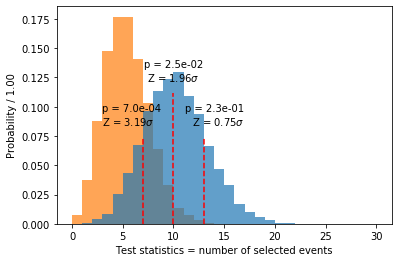

<IPython.core.display.Javascript object>

In [19]:
binning = [30, 0, 30]  # nbins, min, max

# just guess something
expected_numbers = {
    "nue": 5.1,
    "numu": 3.3,
    "dirt": 0.1,
    "dataext": 1.3,
    "data": 9,
    "nue_signal": 4.9,
    "nue_nonsignal": 0.2,
}

test_statistics_distribution_given_numbers(
    binning, expected_numbers, data_on=False, n_toy=10000, log=False
)

#### Data/MC comparison

MC category: $\nu_e$ CC other: 3.4 	#entries 62
MC category: $\nu_e$ CC 0$\pi$0p: 1.0 	#entries 19
MC category: $\nu_e$ CC 0$\pi$Np: 7.0 	#entries 125
MC category: $\nu_{\mu}$ CC other: 1.2 	#entries 21
MC category: $\nu_{\mu}$ CC $\pi^{0}$: 2.3 	#entries 41
MC category: $\nu$ NC: 0.7 	#entries 13
MC category: $\nu$ NC $\pi^{0}$: 2.6 	#entries 47
MC category: Cosmic: 1.4 	#entries 25
MC category: Out of FV: 1.7 	#entries 30


/home/wouter/Documents/Jupyter/searchingfornues/helpers/helpplots.py:363: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf1we = cwei1[[np.searchsorted(data1, data, side='right')]]
/home/wouter/Documents/Jupyter/searchingfornues/helpers/helpplots.py:364: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf2we = cwei2[[np.searchsorted(data2, data, side='right')]]


DRT: 0.59
CPU times: user 5.25 s, sys: 115 ms, total: 5.37 s
Wall time: 3.68 s


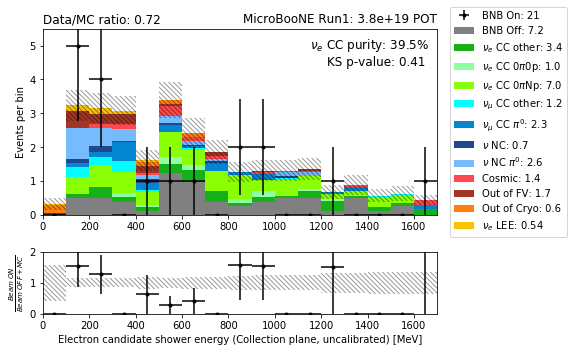

<IPython.core.display.Javascript object>

In [20]:
%%time
%autoreload
fig, ax = plt.subplots(
    ncols=1,
    nrows=2,
    figsize=(5 * plothelp.gr, 5),
    gridspec_kw={"height_ratios": [3, 1]},
)

ratio,purity, ks_p = plothelp.plot_panel_data_mc(
    data,
    ax,
    "shr_energy_y_v",
    "Electron candidate shower energy (Collection plane, uncalibrated) [MeV]",
    N_bins=17,
    x_min=0,
    x_max=1700,
    query=q_s,
    legend=True,
    title_str=title_str,
    kind="event_category",
    y_max_scaler=1.1
)
ax[0].text(
    ax[0].get_xlim()[1] * 0.98,
    ax[0].get_ylim()[1] * 0.8,
    r"$\nu_e$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)

#ax[0].set_ylim(0, 0.3)
fig.tight_layout()
fig.savefig(output_dir + "data_mc/nue_shower_energy_y.pdf", bbox_inches="tight")

MC category: $\nu_e$ CC other: 3.4 	#entries 62
MC category: $\nu_e$ CC 0$\pi$0p: 1.0 	#entries 19
MC category: $\nu_e$ CC 0$\pi$Np: 7.0 	#entries 125
MC category: $\nu_{\mu}$ CC other: 1.2 	#entries 21
MC category: $\nu_{\mu}$ CC $\pi^{0}$: 2.3 	#entries 41
MC category: $\nu$ NC: 0.7 	#entries 13
MC category: $\nu$ NC $\pi^{0}$: 2.6 	#entries 47
MC category: Cosmic: 1.4 	#entries 25
MC category: Out of FV: 1.7 	#entries 30


/home/wouter/Documents/Jupyter/searchingfornues/helpers/helpplots.py:363: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf1we = cwei1[[np.searchsorted(data1, data, side='right')]]
/home/wouter/Documents/Jupyter/searchingfornues/helpers/helpplots.py:364: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf2we = cwei2[[np.searchsorted(data2, data, side='right')]]


DRT: 0.59
CPU times: user 3.13 s, sys: 24.1 ms, total: 3.15 s
Wall time: 1.9 s


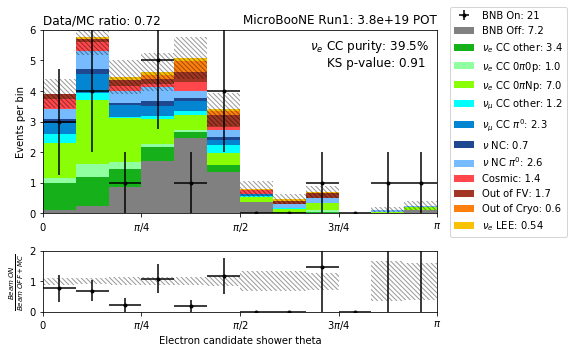

<IPython.core.display.Javascript object>

In [21]:
%%time
fig, ax = plt.subplots(
    ncols=1,
    nrows=2,
    figsize=(5 * plothelp.gr, 5),
    gridspec_kw={"height_ratios": [3, 1]},
)

ratio,purity, ks_p = plothelp.plot_panel_data_mc(
    data,
    ax,
    "shr_tkfit_theta_v",
    "Electron candidate shower theta",
    N_bins=12,
    x_min=0,
    x_max=np.pi,
    query=q_s,
    legend=True,
    title_str=title_str,
    kind="event_category",
    y_max_scaler=1.2
)
ax[0].text(
    ax[0].get_xlim()[1] * 0.98,
    ax[0].get_ylim()[1] * 0.8,
    r"$\nu_e$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)

x_ticks = [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4, np.pi]
x_labels = [r"$0$", r"$\pi/4$", r"$\pi/2$", r"$3\pi/4$", r"$\pi$"]
ax[1].set_xticks(x_ticks)
ax[1].set_xticklabels(x_labels)
ax[0].set_xticks(x_ticks)
ax[0].set_xticklabels(x_labels)

fig.tight_layout()
fig.savefig(output_dir + "data_mc/nue_shower_theta.pdf", bbox_inches="tight")

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.06 µs
MC category: $p$: 21.9 	#entries 398
MC category: $\mu$: 36.4 	#entries 651
MC category: $e$: 27.8 	#entries 500
MC category: $\pi^{\pm}$: 35.5 	#entries 645
MC category: $\gamma$: 514.6 	#entries 9353
MC category: $K$: 0.2 	#entries 4
MC category: Cosmic: 191.1 	#entries 3469


/home/wouter/Documents/Jupyter/searchingfornues/helpers/helpplots.py:363: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf1we = cwei1[[np.searchsorted(data1, data, side='right')]]
/home/wouter/Documents/Jupyter/searchingfornues/helpers/helpplots.py:364: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf2we = cwei2[[np.searchsorted(data2, data, side='right')]]


DRT: 14.


/home/wouter/Documents/Jupyter/searchingfornues/helpers/helpplots.py:268: RuntimeWarning: invalid value encountered in double_scalars
  sc_err = e / v
/home/wouter/Documents/Jupyter/searchingfornues/helpers/helpplots.py:292: RuntimeWarning: invalid value encountered in true_divide
  bins[-1] / val,
/home/wouter/Documents/Jupyter/searchingfornues/helpers/helpplots.py:294: RuntimeWarning: invalid value encountered in true_divide
  yerr=err_on / val,


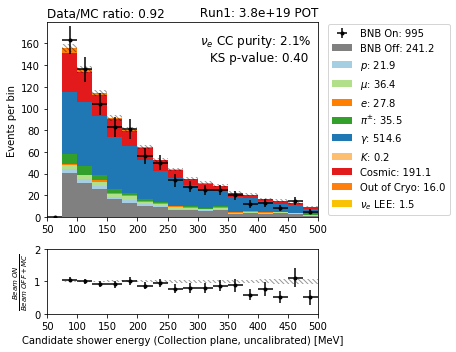

<IPython.core.display.Javascript object>

In [22]:
%time
fig, ax = plt.subplots(
    ncols=1,
    nrows=2,
    figsize=(4 * plothelp.gr, 5),
    gridspec_kw={"height_ratios": [3, 1]},
)

ratio, purity, ks_p = plothelp.plot_panel_data_mc(
    data,
    ax,
    "shr_energy_y_v",
    "Candidate shower energy (Collection plane, uncalibrated) [MeV]",
    N_bins=18,
    x_min=50,
    x_max=500,
    query="e_candidate>0 & preselect",
    legend=True,
    title_str=title_str.split("NE")[-1],
    kind="event_pdg",
    y_max_scaler=1.1,
)
ax[0].text(
    ax[0].get_xlim()[1] * 0.98,
    ax[0].get_ylim()[1] * 0.8,
    r"$\nu_e$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)
fig.tight_layout()
fig.savefig(output_dir + "data_mc/pre_shower_E_pdg.pdf", bbox_inches="tight")

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 8.58 µs
MC category: $\nu_e$ CC other: 9.9 	#entries 180
MC category: $\nu_e$ CC 0$\pi$0p: 2.2 	#entries 39
MC category: $\nu_e$ CC 0$\pi$Np: 11.3 	#entries 203
MC category: $\nu_{\mu}$ CC other: 149.1 	#entries 2701
MC category: $\nu_{\mu}$ CC $\pi^{0}$: 330.9 	#entries 6014
MC category: $\nu$ NC: 20.5 	#entries 372
MC category: $\nu$ NC $\pi^{0}$: 128.0 	#entries 2325
MC category: Cosmic: 78.1 	#entries 1416
MC category: Out of FV: 97.6 	#entries 1770


/home/wouter/Documents/Jupyter/searchingfornues/helpers/helpplots.py:363: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf1we = cwei1[[np.searchsorted(data1, data, side='right')]]
/home/wouter/Documents/Jupyter/searchingfornues/helpers/helpplots.py:364: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf2we = cwei2[[np.searchsorted(data2, data, side='right')]]


DRT: 14.


/home/wouter/Documents/Jupyter/searchingfornues/helpers/helpplots.py:268: RuntimeWarning: invalid value encountered in double_scalars
  sc_err = e / v
/home/wouter/Documents/Jupyter/searchingfornues/helpers/helpplots.py:292: RuntimeWarning: invalid value encountered in true_divide
  bins[-1] / val,
/home/wouter/Documents/Jupyter/searchingfornues/helpers/helpplots.py:294: RuntimeWarning: invalid value encountered in true_divide
  yerr=err_on / val,


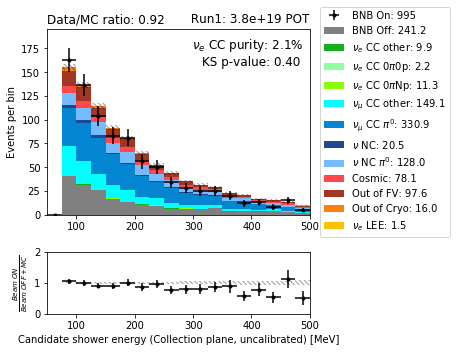

<IPython.core.display.Javascript object>

In [23]:
%time
fig, ax = plt.subplots(
    ncols=1,
    nrows=2,
    figsize=(4 * plothelp.gr, 5),
    gridspec_kw={"height_ratios": [3, 1]},
)

ratio, purity, ks_p = plothelp.plot_panel_data_mc(
    data,
    ax,
    "shr_energy_y_v",
    "Candidate shower energy (Collection plane, uncalibrated) [MeV]",
    N_bins=18,
    x_min=50,
    x_max=500,
    query="e_candidate>0 & preselect",
    legend=True,
    title_str=title_str.split("NE")[-1],
    kind="event_category",
    y_max_scaler=1.2,
)
ax[0].text(
    ax[0].get_xlim()[1] * 0.98,
    ax[0].get_ylim()[1] * 0.8,
    r"$\nu_e$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)
fig.tight_layout()
fig.savefig(output_dir + "data_mc/pre_shower_E.pdf", bbox_inches="tight")

MC category: $\nu_e$ CC other: 9.9 	#entries 180
MC category: $\nu_e$ CC 0$\pi$0p: 2.2 	#entries 39
MC category: $\nu_e$ CC 0$\pi$Np: 11.3 	#entries 203
MC category: $\nu_{\mu}$ CC other: 149.1 	#entries 2701
MC category: $\nu_{\mu}$ CC $\pi^{0}$: 330.9 	#entries 6014
MC category: $\nu$ NC: 20.5 	#entries 372
MC category: $\nu$ NC $\pi^{0}$: 128.0 	#entries 2325
MC category: Cosmic: 78.1 	#entries 1416
MC category: Out of FV: 97.6 	#entries 1770


/home/wouter/Documents/Jupyter/searchingfornues/helpers/helpplots.py:363: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf1we = cwei1[[np.searchsorted(data1, data, side='right')]]
/home/wouter/Documents/Jupyter/searchingfornues/helpers/helpplots.py:364: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf2we = cwei2[[np.searchsorted(data2, data, side='right')]]


DRT: 15.
MC category: $\nu_e$ CC other: 9.9 	#entries 180
MC category: $\nu_e$ CC 0$\pi$0p: 2.2 	#entries 39
MC category: $\nu_e$ CC 0$\pi$Np: 11.3 	#entries 203
MC category: $\nu_{\mu}$ CC other: 149.1 	#entries 2701
MC category: $\nu_{\mu}$ CC $\pi^{0}$: 330.9 	#entries 6014
MC category: $\nu$ NC: 20.5 	#entries 372
MC category: $\nu$ NC $\pi^{0}$: 128.0 	#entries 2325
MC category: Cosmic: 78.1 	#entries 1416
MC category: Out of FV: 97.6 	#entries 1770
DRT: 15.
MC category: $\nu_e$ CC other: 9.9 	#entries 180
MC category: $\nu_e$ CC 0$\pi$0p: 2.2 	#entries 39
MC category: $\nu_e$ CC 0$\pi$Np: 11.3 	#entries 203
MC category: $\nu_{\mu}$ CC other: 149.1 	#entries 2701
MC category: $\nu_{\mu}$ CC $\pi^{0}$: 330.9 	#entries 6014
MC category: $\nu$ NC: 20.5 	#entries 372
MC category: $\nu$ NC $\pi^{0}$: 128.0 	#entries 2325
MC category: Cosmic: 78.1 	#entries 1416
MC category: Out of FV: 97.6 	#entries 1770
DRT: 16.


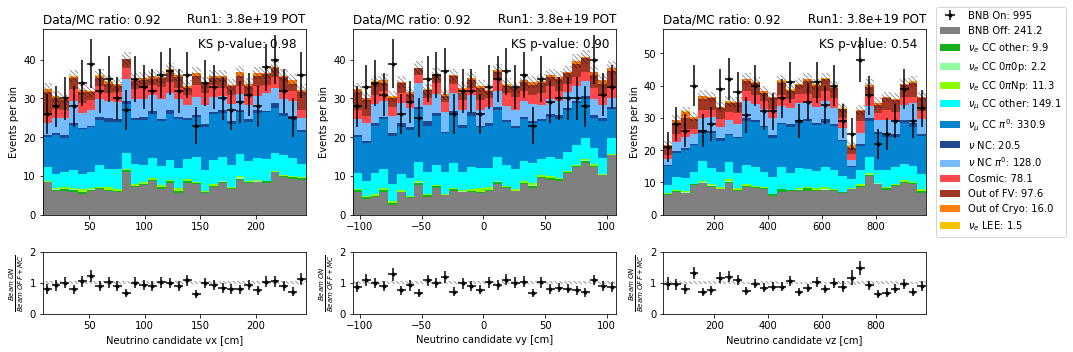

<IPython.core.display.Javascript object>

In [24]:
fig, ax = plt.subplots(
    ncols=3, nrows=2, figsize=(15, 5), gridspec_kw={"height_ratios": [3, 1]}
)


field_arr = ["reco_nu_vtx_sce_x", "reco_nu_vtx_sce_y", "reco_nu_vtx_sce_z"]
lab_arr = [
    "Neutrino candidate vx [cm]",
    "Neutrino candidate vy [cm]",
    "Neutrino candidate vz [cm]",
]
x_min_arr = helper.lower + np.array([10, 10, 10])
x_max_arr = helper.upper - np.array([10, 10, 50])

for i, (x_min, x_max, lab, field) in enumerate(
    zip(x_min_arr, x_max_arr, lab_arr, field_arr)
):
    ratio, purity, ks_p = plothelp.plot_panel_data_mc(
        data,
        ax.T[i],
        field,
        lab,
        N_bins=30,
        x_min=x_min,
        x_max=x_max,
        query="e_candidate>0 & preselect",
        legend=(i == 2),
        title_str=title_str.split("NE")[-1],
        kind="event_category",
        y_max_scaler=1.2,
    )
    ax[0][i].text(
        ax[0][i].get_xlim()[1] * 0.98,
        ax[0][i].get_ylim()[1] * 0.9,
        "KS p-value: {0:<5.2f}".format(ks_p),
        horizontalalignment="right",
        fontsize=12,
    )

fig.tight_layout()
fig.savefig(output_dir + "data_mc/pre_vtx.pdf", bbox_inches="tight")

MC category: $\nu_e$ CC other: 9.9 	#entries 180
MC category: $\nu_e$ CC 0$\pi$0p: 2.2 	#entries 39
MC category: $\nu_e$ CC 0$\pi$Np: 11.3 	#entries 203
MC category: $\nu_{\mu}$ CC other: 149.1 	#entries 2701
MC category: $\nu_{\mu}$ CC $\pi^{0}$: 330.9 	#entries 6014
MC category: $\nu$ NC: 20.5 	#entries 372
MC category: $\nu$ NC $\pi^{0}$: 128.0 	#entries 2325
MC category: Cosmic: 78.1 	#entries 1416
MC category: Out of FV: 97.6 	#entries 1770


/home/wouter/Documents/Jupyter/searchingfornues/helpers/helpplots.py:363: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf1we = cwei1[[np.searchsorted(data1, data, side='right')]]
/home/wouter/Documents/Jupyter/searchingfornues/helpers/helpplots.py:364: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf2we = cwei2[[np.searchsorted(data2, data, side='right')]]


DRT: 16.
MC category: $\nu_e$ CC other: 9.9 	#entries 180
MC category: $\nu_e$ CC 0$\pi$0p: 2.2 	#entries 39
MC category: $\nu_e$ CC 0$\pi$Np: 11.3 	#entries 203
MC category: $\nu_{\mu}$ CC other: 149.1 	#entries 2701
MC category: $\nu_{\mu}$ CC $\pi^{0}$: 330.9 	#entries 6014
MC category: $\nu$ NC: 20.5 	#entries 372
MC category: $\nu$ NC $\pi^{0}$: 128.0 	#entries 2325
MC category: Cosmic: 78.1 	#entries 1416
MC category: Out of FV: 97.6 	#entries 1770
DRT: 16.


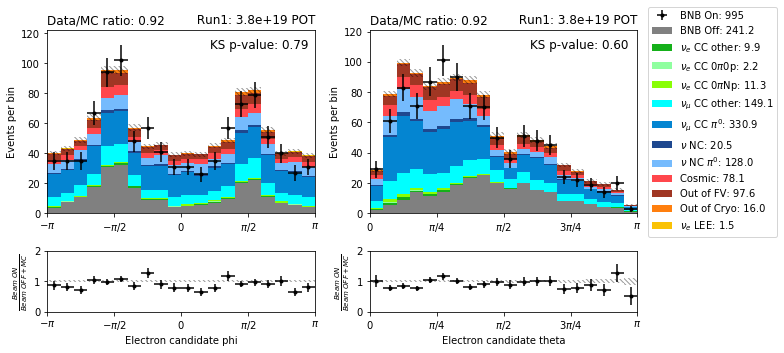

<IPython.core.display.Javascript object>

In [25]:
fig, ax = plt.subplots(
    ncols=2, nrows=2, figsize=(11, 5), gridspec_kw={"height_ratios": [3, 1]}
)

ratio, purity, ks_p = plothelp.plot_panel_data_mc(
    data,
    ax.T[0],
    "shr_tkfit_phi_v",
    "Electron candidate phi",
    N_bins=20,
    x_min=-np.pi,
    x_max=np.pi,
    legend=False,
    query="e_candidate>0 & preselect",
    title_str=title_str.split("NE")[-1],
    kind="event_category",
    y_max_scaler=1.2,
)
x_ticks = [-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi]
x_labels = [r"$-\pi$", r"$-\pi/2$", r"$0$", r"$\pi/2$", r"$\pi$"]
ax[1][0].set_xticks(x_ticks)
ax[1][0].set_xticklabels(x_labels)
ax[0][0].set_xticks(x_ticks)
ax[0][0].set_xticklabels(x_labels)
ax[0][0].text(
    ax[0][0].get_xlim()[1] * 0.98,
    ax[0][0].get_ylim()[1] * 0.9,
    "KS p-value: {0:<5.2f}".format(ks_p),
    horizontalalignment="right",
    fontsize=12,
)

ratio, purity, ks_p = plothelp.plot_panel_data_mc(
    data,
    ax.T[1],
    "shr_tkfit_theta_v",
    "Electron candidate theta",
    N_bins=20,
    x_min=0,
    x_max=np.pi,
    legend=True,
    query="e_candidate>0 & preselect",
    title_str=title_str.split("NE")[-1],
    kind="event_category",
    y_max_scaler=1.2,
)
x_ticks = [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4, np.pi]
x_labels = [r"$0$", r"$\pi/4$", r"$\pi/2$", r"$3\pi/4$", r"$\pi$"]
ax[1][1].set_xticks(x_ticks)
ax[1][1].set_xticklabels(x_labels)
ax[0][1].set_xticks(x_ticks)
ax[0][1].set_xticklabels(x_labels)
ax[0][1].text(
    ax[0][1].get_xlim()[1] * 0.98,
    ax[0][1].get_ylim()[1] * 0.9,
    "KS p-value: {0:<5.2f}".format(ks_p),
    horizontalalignment="right",
    fontsize=12,
)

fig.tight_layout()
fig.savefig(output_dir + "data_mc/pre_angles.pdf", bbox_inches="tight")

MC category: $p$: 21.9 	#entries 398
MC category: $\mu$: 36.4 	#entries 651
MC category: $e$: 27.8 	#entries 500
MC category: $\pi^{\pm}$: 35.5 	#entries 645
MC category: $\gamma$: 514.6 	#entries 9353
MC category: $K$: 0.2 	#entries 4
MC category: Cosmic: 191.1 	#entries 3469


/home/wouter/Documents/Jupyter/searchingfornues/helpers/helpplots.py:363: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf1we = cwei1[[np.searchsorted(data1, data, side='right')]]
/home/wouter/Documents/Jupyter/searchingfornues/helpers/helpplots.py:364: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf2we = cwei2[[np.searchsorted(data2, data, side='right')]]


DRT: 11.
MC category: $p$: 21.9 	#entries 398
MC category: $\mu$: 36.4 	#entries 651
MC category: $e$: 27.8 	#entries 500
MC category: $\pi^{\pm}$: 35.5 	#entries 645
MC category: $\gamma$: 514.6 	#entries 9353
MC category: $K$: 0.2 	#entries 4
MC category: Cosmic: 191.1 	#entries 3469
DRT: 13.


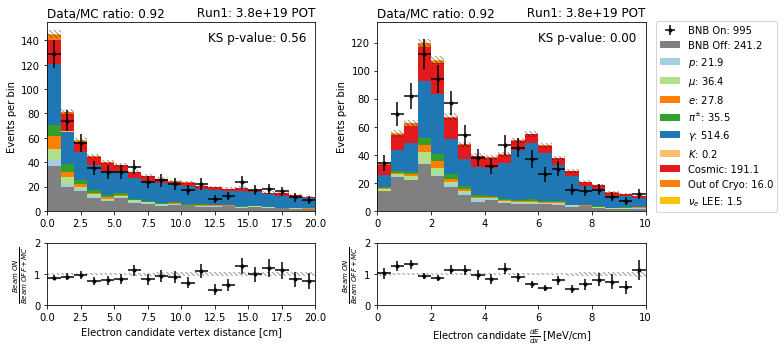

<IPython.core.display.Javascript object>

In [26]:
fig, ax = plt.subplots(
    ncols=2, nrows=2, figsize=(11, 5), gridspec_kw={"height_ratios": [3, 1]}
)

ratio, purity, ks_p = plothelp.plot_panel_data_mc(
    data,
    ax.T[0],
    "shr_dist_v",
    "Electron candidate vertex distance [cm]",
    N_bins=20,
    x_min=0,
    x_max=20,
    legend=False,
    query="e_candidate>0 & preselect",
    title_str=title_str.split("NE")[-1],
    kind="event_pdg",
    y_max_scaler=1.2,
)
ax[0][0].text(
    ax[0][0].get_xlim()[1] * 0.98,
    ax[0][0].get_ylim()[1] * 0.9,
    "KS p-value: {0:<5.2f}".format(ks_p),
    horizontalalignment="right",
    fontsize=12,
)

ratio, purity, ks_p = plothelp.plot_panel_data_mc(
    data,
    ax.T[1],
    "shr_tkfit_dedx_y_v",
    r"Electron candidate $\frac{dE}{dx}$ [MeV/cm]",
    N_bins=20,
    x_min=0,
    x_max=10,
    legend=True,
    query="e_candidate>0 & preselect",
    title_str=title_str.split("NE")[-1],
    kind="event_pdg",
    y_max_scaler=1.2,
)
ax[0][1].text(
    ax[0][1].get_xlim()[1] * 0.98,
    ax[0][1].get_ylim()[1] * 0.9,
    "KS p-value: {0:<5.2f}".format(ks_p),
    horizontalalignment="right",
    fontsize=12,
)

fig.tight_layout()
fig.savefig(output_dir + "data_mc/pre_shwrfields.pdf", bbox_inches="tight")

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.25 µs
MC category: $p$: 21.9 	#entries 398
MC category: $\mu$: 36.4 	#entries 651
MC category: $e$: 27.8 	#entries 500
MC category: $\pi^{\pm}$: 35.5 	#entries 645
MC category: $\gamma$: 514.6 	#entries 9353
MC category: $K$: 0.2 	#entries 4
MC category: Cosmic: 191.1 	#entries 3469


/home/wouter/Documents/Jupyter/searchingfornues/helpers/helpplots.py:363: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf1we = cwei1[[np.searchsorted(data1, data, side='right')]]
/home/wouter/Documents/Jupyter/searchingfornues/helpers/helpplots.py:364: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf2we = cwei2[[np.searchsorted(data2, data, side='right')]]


DRT: 16.


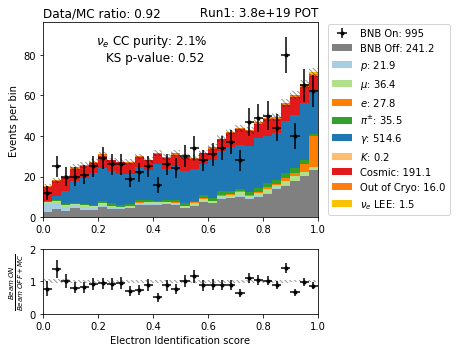

<IPython.core.display.Javascript object>

In [27]:
%time
fig, ax = plt.subplots(
    ncols=1,
    nrows=2,
    figsize=(4 * plothelp.gr, 5),
    gridspec_kw={"height_ratios": [3, 1]},
)

ratio, purity, ks_p = plothelp.plot_panel_data_mc(
    data,
    ax,
    "score",
    "Electron Identification score",
    N_bins=30,
    x_min=0,
    x_max=1,
    query="e_candidate>0 & preselect",
    legend=True,
    title_str=title_str.split("NE")[-1],
    kind="event_pdg",
    y_max_scaler=1.2,
)
ax[0].text(
    ax[0].get_xlim()[1] * 0.6,
    ax[0].get_ylim()[1] * 0.8,
    r"$\nu_e$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)

fig.tight_layout()
fig.savefig(output_dir + "data_mc/pre_e_score.pdf", bbox_inches="tight")

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.48 µs
MC category: $p$: 589.3 	#entries 10707
MC category: $\mu$: 539.3 	#entries 9801
MC category: $e$: 24.0 	#entries 432
MC category: $\pi^{\pm}$: 185.5 	#entries 3370
MC category: $\gamma$: 575.2 	#entries 10453
MC category: $K$: 3.2 	#entries 59
MC category: Cosmic: 670.6 	#entries 12182


/home/wouter/Documents/Jupyter/searchingfornues/helpers/helpplots.py:363: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf1we = cwei1[[np.searchsorted(data1, data, side='right')]]
/home/wouter/Documents/Jupyter/searchingfornues/helpers/helpplots.py:364: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf2we = cwei2[[np.searchsorted(data2, data, side='right')]]


DRT: 27.


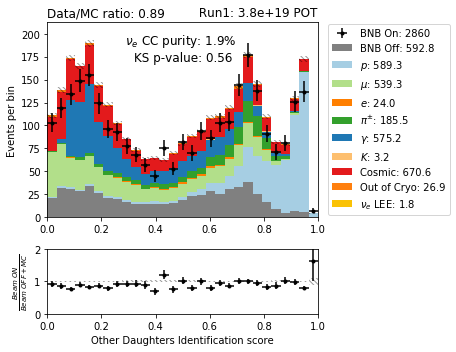

<IPython.core.display.Javascript object>

In [28]:
%time
fig, ax = plt.subplots(
    ncols=1,
    nrows=2,
    figsize=(4 * plothelp.gr, 5),
    gridspec_kw={"height_ratios": [3, 1]},
)

ratio, purity, ks_p = plothelp.plot_panel_data_mc(
    data,
    ax,
    "score",
    "Other Daughters Identification score",
    N_bins=29,
    x_min=0,
    x_max=1,
    query="~e_candidate>0 & preselect",
    legend=True,
    title_str=title_str.split("NE")[-1],
    kind="event_pdg",
    y_max_scaler=1.2,
)
ax[0].text(
    ax[0].get_xlim()[1] * 0.7,
    ax[0].get_ylim()[1] * 0.8,
    r"$\nu_e$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)

fig.tight_layout()
fig.savefig(output_dir + "data_mc/pre_daughter_score.pdf", bbox_inches="tight")

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 7.63 µs
MC category: $\nu_e$ CC other: 9.9 	#entries 180
MC category: $\nu_e$ CC 0$\pi$0p: 2.2 	#entries 39
MC category: $\nu_e$ CC 0$\pi$Np: 11.3 	#entries 203
MC category: $\nu_{\mu}$ CC other: 149.1 	#entries 2701
MC category: $\nu_{\mu}$ CC $\pi^{0}$: 330.9 	#entries 6014
MC category: $\nu$ NC: 20.5 	#entries 372
MC category: $\nu$ NC $\pi^{0}$: 128.0 	#entries 2325
MC category: Cosmic: 78.1 	#entries 1416
MC category: Out of FV: 97.6 	#entries 1770


/home/wouter/Documents/Jupyter/searchingfornues/helpers/helpplots.py:363: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf1we = cwei1[[np.searchsorted(data1, data, side='right')]]
/home/wouter/Documents/Jupyter/searchingfornues/helpers/helpplots.py:364: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf2we = cwei2[[np.searchsorted(data2, data, side='right')]]


DRT: 16.


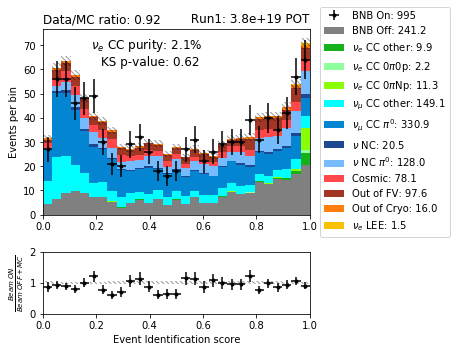

<IPython.core.display.Javascript object>

In [29]:
%time
fig, ax = plt.subplots(
    ncols=1,
    nrows=2,
    figsize=(4 * plothelp.gr, 5),
    gridspec_kw={"height_ratios": [3, 1]},
)

ratio, purity, ks_p = plothelp.plot_panel_data_mc(
    data,
    ax,
    "score_event",
    "Event Identification score",
    N_bins=29,
    x_min=0,
    x_max=1,
    query="e_candidate>0 & preselect",
    legend=True,
    title_str=title_str.split("NE")[-1],
    kind="event_category",
    y_max_scaler=1.2,
)
ax[0].text(
    ax[0].get_xlim()[1] * 0.6,
    ax[0].get_ylim()[1] * 0.8,
    r"$\nu_e$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)

fig.tight_layout()
fig.savefig(output_dir + "data_mc/pre_event_score.pdf", bbox_inches="tight")

MC category: $\nu_e$ CC other: 3.4 	#entries 62
MC category: $\nu_e$ CC 0$\pi$0p: 1.0 	#entries 19
MC category: $\nu_e$ CC 0$\pi$Np: 7.0 	#entries 125
MC category: $\nu_{\mu}$ CC other: 1.2 	#entries 21
MC category: $\nu_{\mu}$ CC $\pi^{0}$: 2.3 	#entries 41
MC category: $\nu$ NC: 0.7 	#entries 13
MC category: $\nu$ NC $\pi^{0}$: 2.6 	#entries 47
MC category: Cosmic: 1.4 	#entries 25
MC category: Out of FV: 1.7 	#entries 30


/home/wouter/Documents/Jupyter/searchingfornues/helpers/helpplots.py:363: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf1we = cwei1[[np.searchsorted(data1, data, side='right')]]
/home/wouter/Documents/Jupyter/searchingfornues/helpers/helpplots.py:364: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf2we = cwei2[[np.searchsorted(data2, data, side='right')]]


DRT: 0.59
MC category: $\nu_e$ CC other: 3.4 	#entries 62
MC category: $\nu_e$ CC 0$\pi$0p: 1.0 	#entries 19
MC category: $\nu_e$ CC 0$\pi$Np: 7.0 	#entries 125
MC category: $\nu_{\mu}$ CC other: 1.2 	#entries 21
MC category: $\nu_{\mu}$ CC $\pi^{0}$: 2.3 	#entries 41
MC category: $\nu$ NC: 0.7 	#entries 13
MC category: $\nu$ NC $\pi^{0}$: 2.6 	#entries 47
MC category: Cosmic: 1.4 	#entries 25
MC category: Out of FV: 1.7 	#entries 30
DRT: 0.59


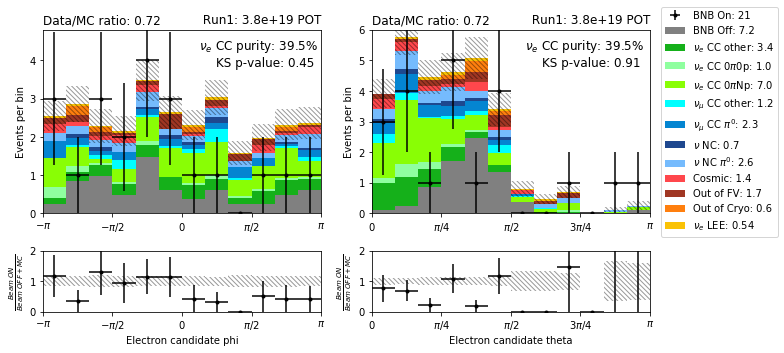

<IPython.core.display.Javascript object>

In [30]:
fig, ax = plt.subplots(
    ncols=2, nrows=2, figsize=(11, 5), gridspec_kw={"height_ratios": [3, 1]}
)

ratio, purity, ks_p = plothelp.plot_panel_data_mc(
    data,
    ax.T[0],
    "shr_tkfit_phi_v",
    "Electron candidate phi",
    N_bins=12,
    x_min=-np.pi,
    x_max=np.pi,
    legend=False,
    query=q_s,
    title_str=title_str.split("NE")[-1],
    kind="event_category",
    y_max_scaler=1.2,
)
x_ticks = [-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi]
x_labels = [r"$-\pi$", r"$-\pi/2$", r"$0$", r"$\pi/2$", r"$\pi$"]
ax[1][0].set_xticks(x_ticks)
ax[1][0].set_xticklabels(x_labels)
ax[0][0].set_xticks(x_ticks)
ax[0][0].set_xticklabels(x_labels)

ax[0][0].text(
    ax[0][0].get_xlim()[1] * 0.98,
    ax[0][0].get_ylim()[1] * 0.8,
    r"$\nu_e$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)

ratio, purity, ks_p = plothelp.plot_panel_data_mc(
    data,
    ax.T[1],
    "shr_tkfit_theta_v",
    "Electron candidate theta",
    N_bins=12,
    x_min=0,
    x_max=np.pi,
    legend=True,
    query=q_s,
    title_str=title_str.split("NE")[-1],
    kind="event_category",
    y_max_scaler=1.2,
)
x_ticks = [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4, np.pi]
x_labels = [r"$0$", r"$\pi/4$", r"$\pi/2$", r"$3\pi/4$", r"$\pi$"]
ax[1][1].set_xticks(x_ticks)
ax[1][1].set_xticklabels(x_labels)
ax[0][1].set_xticks(x_ticks)
ax[0][1].set_xticklabels(x_labels)

ax[0][1].text(
    ax[0][1].get_xlim()[1] * 0.98,
    ax[0][1].get_ylim()[1] * 0.8,
    r"$\nu_e$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)

fig.tight_layout()
fig.savefig(output_dir + "data_mc/after_angles.pdf", bbox_inches="tight")

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.25 µs
MC category: $p$: 589.3 	#entries 10707
MC category: $\mu$: 539.3 	#entries 9801
MC category: $e$: 24.0 	#entries 432
MC category: $\pi^{\pm}$: 185.5 	#entries 3370
MC category: $\gamma$: 575.2 	#entries 10453
MC category: $K$: 3.2 	#entries 59
MC category: Cosmic: 670.6 	#entries 12182


/home/wouter/Documents/Jupyter/searchingfornues/helpers/helpplots.py:363: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf1we = cwei1[[np.searchsorted(data1, data, side='right')]]
/home/wouter/Documents/Jupyter/searchingfornues/helpers/helpplots.py:364: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf2we = cwei2[[np.searchsorted(data2, data, side='right')]]


DRT: 26.


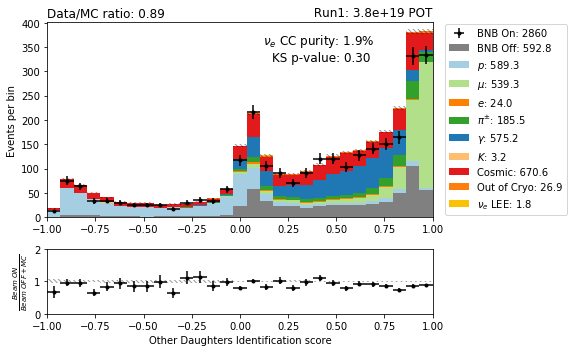

<IPython.core.display.Javascript object>

In [36]:
%time
fig, ax = plt.subplots(
    ncols=1,
    nrows=2,
    figsize=(5 * plothelp.gr, 5),
    gridspec_kw={"height_ratios": [3, 1]},
)

ratio, purity, ks_p = plothelp.plot_panel_data_mc(
    data,
    ax,
    "trk_llr_pid_score_v",
    "Other Daughters Identification score",
    N_bins=29,
    x_min=-1,
    x_max=1,
    query="~e_candidate>0 & preselect",
    legend=True,
    title_str=title_str.split("NE")[-1],
    kind="event_pdg",
    y_max_scaler=1.2,
)
ax[0].text(
    ax[0].get_xlim()[1] * 0.7,
    ax[0].get_ylim()[1] * 0.8,
    r"$\nu_e$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)

fig.tight_layout()
fig.savefig(output_dir + "data_mc/pre_daughter_nico_zoom.pdf", bbox_inches="tight")

MC category: $p$: 21.9 	#entries 398
MC category: $\mu$: 36.4 	#entries 651
MC category: $e$: 27.8 	#entries 500
MC category: $\pi^{\pm}$: 35.5 	#entries 645
MC category: $\gamma$: 514.6 	#entries 9353
MC category: $K$: 0.2 	#entries 4
MC category: Cosmic: 191.1 	#entries 3469


/home/wouter/Documents/Jupyter/searchingfornues/helpers/helpplots.py:363: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf1we = cwei1[[np.searchsorted(data1, data, side='right')]]
/home/wouter/Documents/Jupyter/searchingfornues/helpers/helpplots.py:364: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf2we = cwei2[[np.searchsorted(data2, data, side='right')]]


DRT: 15.
MC category: $p$: 21.9 	#entries 398
MC category: $\mu$: 36.4 	#entries 651
MC category: $e$: 27.8 	#entries 500
MC category: $\pi^{\pm}$: 35.5 	#entries 645
MC category: $\gamma$: 514.6 	#entries 9353
MC category: $K$: 0.2 	#entries 4
MC category: Cosmic: 191.1 	#entries 3469
DRT: 8.1


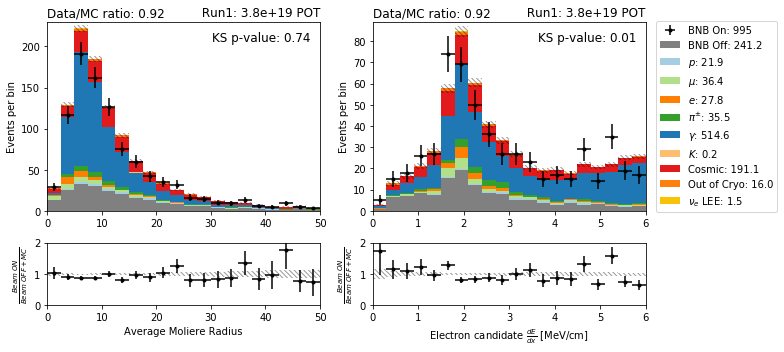

<IPython.core.display.Javascript object>

In [32]:
fig, ax = plt.subplots(
    ncols=2, nrows=2, figsize=(11, 5), gridspec_kw={"height_ratios": [3, 1]}
)

ratio, purity, ks_p = plothelp.plot_panel_data_mc(
    data,
    ax.T[0],
    "shr_moliere_avg_v",
    "Average Moliere Radius",
    N_bins=20,
    x_min=0,
    x_max=50,
    legend=False,
    query="e_candidate>0 & preselect",
    title_str=title_str.split("NE")[-1],
    kind="event_pdg",
    y_max_scaler=1.2,
)
ax[0][0].text(
    ax[0][0].get_xlim()[1] * 0.98,
    ax[0][0].get_ylim()[1] * 0.9,
    "KS p-value: {0:<5.2f}".format(ks_p),
    horizontalalignment="right",
    fontsize=12,
)

ratio, purity, ks_p = plothelp.plot_panel_data_mc(
    data,
    ax.T[1],
    "shr_tkfit_gap10_dedx_y_v",
    r"Electron candidate $\frac{dE}{dx}$ [MeV/cm]",
    N_bins=20,
    x_min=0,
    x_max=6,
    legend=True,
    query="e_candidate>0 & preselect",
    title_str=title_str.split("NE")[-1],
    kind="event_pdg",
    y_max_scaler=1.2,
)
ax[0][1].text(
    ax[0][1].get_xlim()[1] * 0.98,
    ax[0][1].get_ylim()[1] * 0.9,
    "KS p-value: {0:<5.2f}".format(ks_p),
    horizontalalignment="right",
    fontsize=12,
)

fig.tight_layout()
fig.savefig(output_dir + "data_mc/pre_moliere.pdf", bbox_inches="tight")

MC category: $p$: 21.9 	#entries 398
MC category: $\mu$: 36.4 	#entries 651
MC category: $e$: 27.8 	#entries 500
MC category: $\pi^{\pm}$: 35.5 	#entries 645
MC category: $\gamma$: 514.6 	#entries 9353
MC category: $K$: 0.2 	#entries 4
MC category: Cosmic: 191.1 	#entries 3469


/home/wouter/Documents/Jupyter/searchingfornues/helpers/helpplots.py:363: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf1we = cwei1[[np.searchsorted(data1, data, side='right')]]
/home/wouter/Documents/Jupyter/searchingfornues/helpers/helpplots.py:364: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf2we = cwei2[[np.searchsorted(data2, data, side='right')]]


DRT: 16.
MC category: $p$: 21.9 	#entries 398
MC category: $\mu$: 36.4 	#entries 651
MC category: $e$: 27.8 	#entries 500
MC category: $\pi^{\pm}$: 35.5 	#entries 645
MC category: $\gamma$: 514.6 	#entries 9353
MC category: $K$: 0.2 	#entries 4
MC category: Cosmic: 191.1 	#entries 3469
DRT: 16.


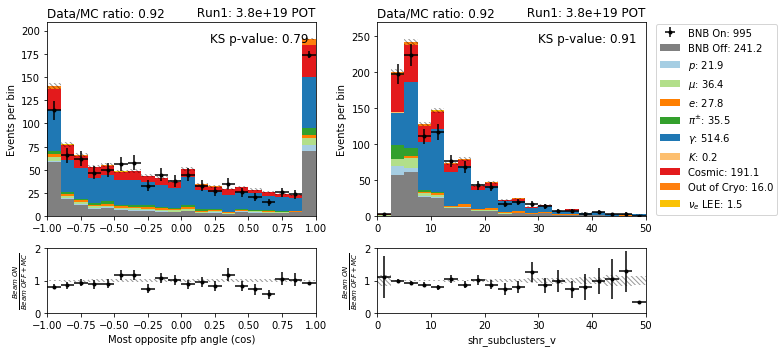

<IPython.core.display.Javascript object>

In [37]:
fig, ax = plt.subplots(
    ncols=2, nrows=2, figsize=(11, 5), gridspec_kw={"height_ratios": [3, 1]}
)

ratio, purity, ks_p = plothelp.plot_panel_data_mc(
    data,
    ax.T[0],
    "trk_min_cos",
    "Most opposite pfp angle (cos)",
    N_bins=20,
    x_min=-1,
    x_max=1,
    legend=False,
    query="e_candidate>0 & preselect",
    title_str=title_str.split("NE")[-1],
    kind="event_pdg",
    y_max_scaler=1.2,
)
ax[0][0].text(
    ax[0][0].get_xlim()[1] * 0.98,
    ax[0][0].get_ylim()[1] * 0.9,
    "KS p-value: {0:<5.2f}".format(ks_p),
    horizontalalignment="right",
    fontsize=12,
)

ratio, purity, ks_p = plothelp.plot_panel_data_mc(
    data,
    ax.T[1],
    "shr_subclusters_v",
    r"shr_subclusters_v",
    N_bins=20,
    x_min=0,
    x_max=50,
    legend=True,
    query="e_candidate>0 & preselect",
    title_str=title_str.split("NE")[-1],
    kind="event_pdg",
    y_max_scaler=1.2,
)
ax[0][1].text(
    ax[0][1].get_xlim()[1] * 0.98,
    ax[0][1].get_ylim()[1] * 0.9,
    "KS p-value: {0:<5.2f}".format(ks_p),
    horizontalalignment="right",
    fontsize=12,
)

fig.tight_layout()
fig.savefig(output_dir + "data_mc/pre_clustershwr.pdf", bbox_inches="tight")

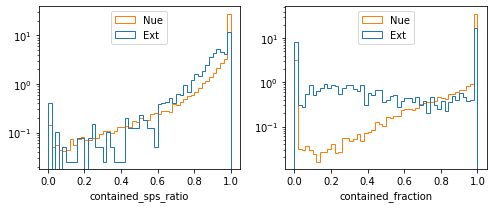

<IPython.core.display.Javascript object>

In [50]:
### PLOT the containment!
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(7, 3))

plot_data = [
    data["off"]["daughters"].query("e_candidate>0 & preselect")["contained_sps_ratio"],
    data["nue"]["daughters"].query("e_candidate>0 & preselect & nueccinc")[
        "contained_sps_ratio"
    ],
    data["off"]["daughters"].query("e_candidate>0 & preselect")["contained_fraction"],
    data["nue"]["daughters"].query("e_candidate>0 & preselect & nueccinc")[
        "contained_fraction"
    ],
]
ax[0].hist(plot_data[0:2], bins=50, density=True, label=["Ext", "Nue"], histtype="step")
ax[0].legend(loc="upper center")
ax[0].set_xlabel("contained_sps_ratio")
ax[0].set_yscale("log")

ax[1].hist(plot_data[2:4], bins=50, density=True, label=["Ext", "Nue"], histtype="step")
ax[1].legend(loc="upper center")
ax[1].set_xlabel("contained_fraction")
ax[1].set_yscale("log")

fig.tight_layout()